In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [75]:
d1=pd.read_csv('AirPassengers.csv')

In [76]:
d1

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


In [77]:
d1 = d1.set_index('Month')

In [78]:
d1.dtypes

#Passengers    int64
dtype: object

In [79]:
d1.index

Index(['1949-01', '1949-02', '1949-03', '1949-04', '1949-05', '1949-06',
       '1949-07', '1949-08', '1949-09', '1949-10',
       ...
       '1960-03', '1960-04', '1960-05', '1960-06', '1960-07', '1960-08',
       '1960-09', '1960-10', '1960-11', '1960-12'],
      dtype='object', name='Month', length=144)

In [80]:
d1.index = pd.to_datetime(d1.index)

In [81]:
d1

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


In [82]:
ts = d1['#Passengers']
ts.head(10)

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
1949-06-01    135
1949-07-01    148
1949-08-01    148
1949-09-01    136
1949-10-01    119
Name: #Passengers, dtype: int64

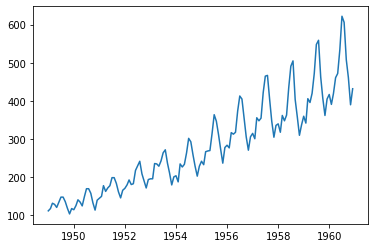

In [83]:
plt.plot(ts)

# Testing Stationarity

In [84]:
from statsmodels.tsa.stattools import adfuller

In [85]:
def rolling_stats(timeseries):
    #Window of 12 months
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

In [86]:
def augmented_dickey_fuller(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    return dfoutput

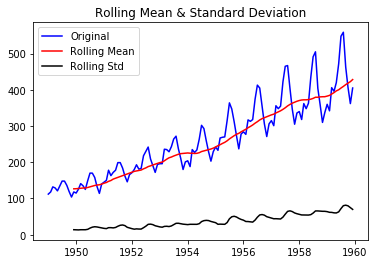

In [87]:
rolling_stats(ts_train)

In [88]:
augmented_dickey_fuller(ts_train)

Test Statistic                   0.888027
p-value                          0.992932
#Lags Used                      13.000000
Number of Observations Used    118.000000
Critical Value (1%)             -3.487022
Critical Value (5%)             -2.886363
Critical Value (10%)            -2.580009
dtype: float64

# Trend Elimination

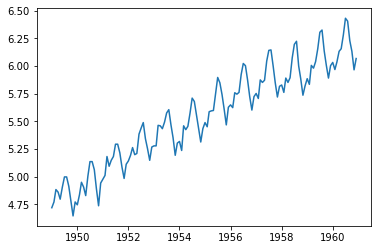

In [89]:
ts_log = np.log(ts)
plt.plot(ts_log)

# Moving Average

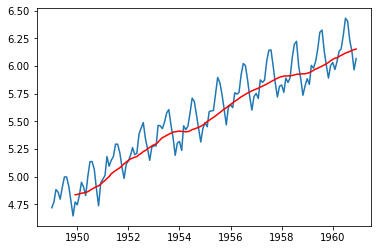

In [90]:
moving_avg = ts_log.rolling(window=12).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

Subtract the rolling average from the time series to reduce the trend.

Note: There are no values for the first 11 values as the window is of 12 months

In [91]:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.head(12)

Month
1949-01-01         NaN
1949-02-01         NaN
1949-03-01         NaN
1949-04-01         NaN
1949-05-01         NaN
1949-06-01         NaN
1949-07-01         NaN
1949-08-01         NaN
1949-09-01         NaN
1949-10-01         NaN
1949-11-01         NaN
1949-12-01   -0.065494
Name: #Passengers, dtype: float64

In [92]:
ts_log_moving_avg_diff.dropna(inplace=True)

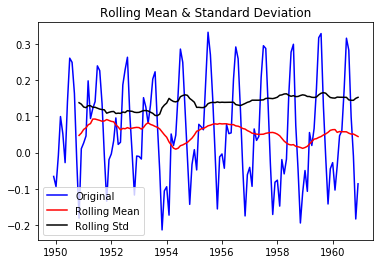

In [93]:
rolling_stats(ts_log_moving_avg_diff)

In [94]:
augmented_dickey_fuller(ts_log_moving_avg_diff)

Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64

This looks like a better time series. The test statistic is lesser than the 5% critical value, so we can say that the series is stationary with 95% confidence.

# Exponential Weighted Moving Average

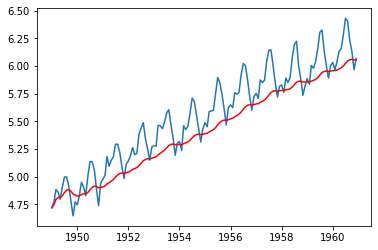

In [95]:
expweighted_avg = ts_log.ewm(halflife=12).mean()
plt.plot(ts_log)
plt.plot(expweighted_avg, color='red')

In [96]:
ts_log_ewma_diff = ts_log - expweighted_avg

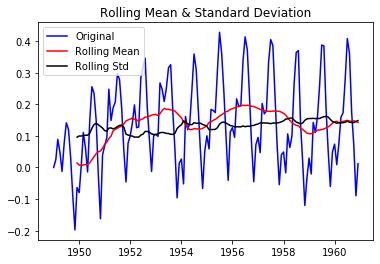

In [97]:
rolling_stats(ts_log_ewma_diff)

In [98]:
augmented_dickey_fuller(ts_log_ewma_diff)

Test Statistic                  -3.601262
p-value                          0.005737
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64

This time, it can be said that the series is stationary with 99% confidence which is better than the previous case. All the values are assigned weights therefore there are no missing values.

# Seasonality Elimination


The simple trend reduction techniques used above do not work in all cases, especially when the seasonality is high. There are better methods to counter seasonality:

#Differencing: Taking the differece with a particular time lag
#Decomposition: Modeling both Trend and Seasonality and removing them from the model.

# Differencing

We take the difference of the observation at a particular instant with that at the previous instant. First order differencing:

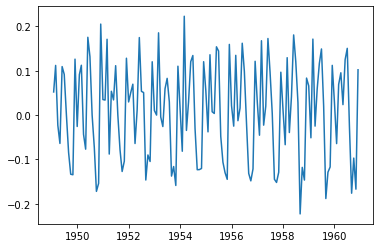

In [99]:
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

In [100]:
ts_log_diff.dropna(inplace=True)

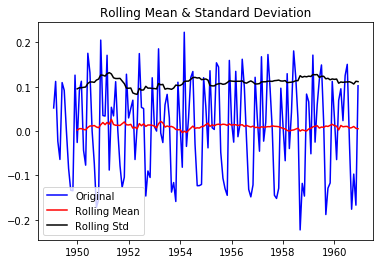

In [101]:
rolling_stats(ts_log_diff)

In [102]:
augmented_dickey_fuller(ts_log_diff)

Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64

We can state the stationarity with 90% confidence

# Decomposing


Both trend and seasonality are modelled separately and the remaining part of the series is returned. For more details watch these videos:

In [103]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [104]:
decomposition = seasonal_decompose(ts_log)

In [105]:
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

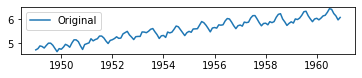

In [106]:
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')

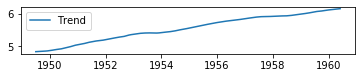

In [107]:
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

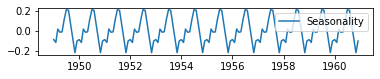

In [108]:
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')

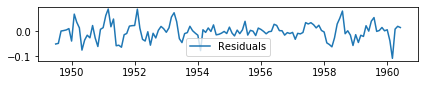

In [109]:
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

Now that the trend and seasonality has been removed, the residuals can be analysed for stationarity.

In [110]:

ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)

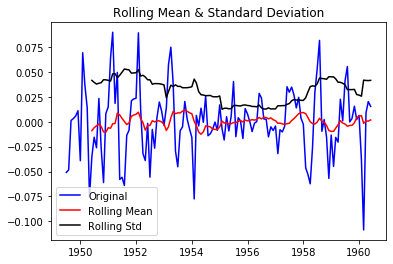

In [111]:
rolling_stats(ts_log_decompose)

In [112]:
augmented_dickey_fuller(ts_log_decompose)

Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (1%)           -3.485122e+00
Critical Value (5%)           -2.885538e+00
Critical Value (10%)          -2.579569e+00
dtype: float64

# Forecasting

# ACF and PACF

In [113]:

from statsmodels.tsa.stattools import acf, pacf

In [114]:
lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')


C:\Users\Manoj\anaconda31\lib\site-packages\statsmodels\tsa\stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


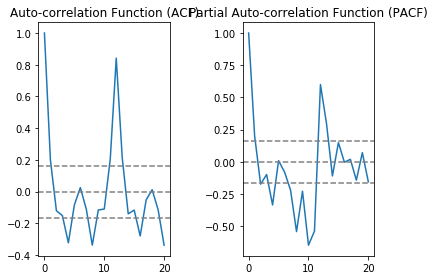

In [115]:

plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Auto-correlation Function (ACF)')

plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Auto-correlation Function (PACF)')
plt.tight_layout()

The two dotted lines on the either side of zero are confidence intervals that can be used to determine values for p and q.

#p – The lag value where the PACF chart crosses the upper confidence interval for the first time. If you notice closely, in this case p=2.
#q – The lag value where the ACF chart crosses the upper confidence interval for the first time. If you notice closely, in this case q=2.

# ARIMA Model

We will prepare 3 different models considering the individual as well as the combined effects.

The parameters required for the ARIMA model can be filled in a tuple in the order (p,d,q)

# Case 1: AR Model

In [116]:
from statsmodels.tsa.arima_model import ARIMA

C:\Users\Manoj\anaconda31\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Manoj\anaconda31\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RSS: 1.5023')

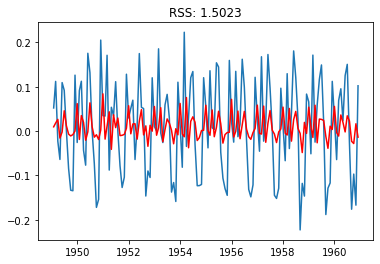

In [117]:
model1 = ARIMA(ts_log, order=(2, 1, 0))  
results_AR = model1.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff)**2))


# Case 2: MA Model

C:\Users\Manoj\anaconda31\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Manoj\anaconda31\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RSS: 1.4721')

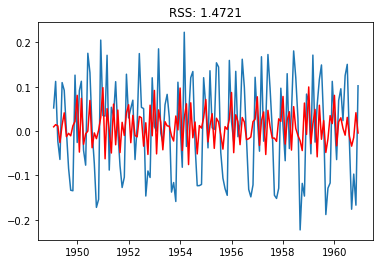

In [118]:
model2 = ARIMA(ts_log, order=(0, 1, 2))  
results_MA = model2.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_log_diff)**2))

# Case 3: Combined Model

C:\Users\Manoj\anaconda31\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Manoj\anaconda31\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Manoj\anaconda31\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\Manoj\anaconda31\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\Manoj\anaconda31\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\Manoj\anaconda31\lib\site-packages

Text(0.5, 1.0, 'RSS: 1.0292')

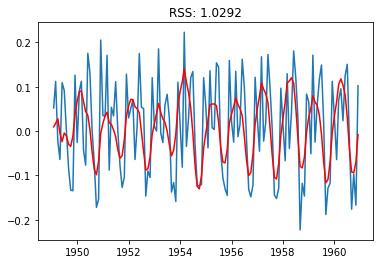

In [119]:
model = ARIMA(ts_log, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))


Inference: The AR and MA models are almost the same, however the combined model has performed better with a relatively low RSS.

# Restoring to Original Scale

In [120]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff.head()

Month
1949-02-01    0.009580
1949-03-01    0.017491
1949-04-01    0.027670
1949-05-01   -0.004521
1949-06-01   -0.023890
dtype: float64

In [121]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.head()

Month
1949-02-01    0.009580
1949-03-01    0.027071
1949-04-01    0.054742
1949-05-01    0.050221
1949-06-01    0.026331
dtype: float64

In [122]:
predictions_ARIMA_log = pd.Series(ts_log.iloc[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

Month
1949-01-01    4.718499
1949-02-01    4.728079
1949-03-01    4.745570
1949-04-01    4.773241
1949-05-01    4.768720
dtype: float64

Text(0.5, 1.0, 'RMSE: 90.1046')

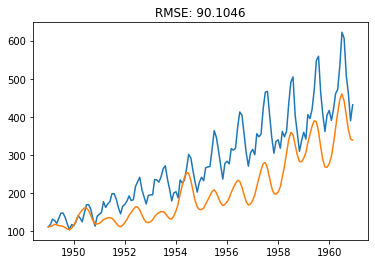

In [123]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))

In [134]:
fcast = results_ARIMA.predict(len(ts_log),len(ts_log)+12,typ='levels',dynamic=True).rename('ARIMA Forecast')

In [138]:
fcast=np.exp(fcast)

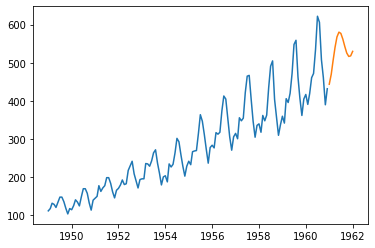

In [139]:
plt.plot(ts)
plt.plot(fcast)